In [1]:
import os
import glob
import math
import chardet, csv
import pandas as pd                      
import matplotlib.pyplot as plt         
import seaborn as sns                   
from scipy.stats import ( 
    kstest,
    shapiro,      # Shapiro–Wilk normaaljaotuse test
    levene,       # Levene’i test dispersioonide võrdlemiseks
    ttest_ind,    # kahe sõltumatu valimi t-test
    mannwhitneyu,  # Mann–Whitney U-test (mitteparameetriline)
    chisquare
)
from statsmodels.stats.multitest import multipletests
import pingouin as pg
import numpy as np
import matplotlib.pyplot as plt

from __future__ import annotations
from typing import List, Optional

In [2]:
total_m = 350146
total_n = 290431

In [3]:
def loe_csv_automaatselt(path):

    with open(path, 'rb') as f:
        enc = chardet.detect(f.read(10000))['encoding']

    with open(path, encoding=enc) as f:
        sample = f.read(2048)
        dialect = csv.Sniffer().sniff(sample)
    return pd.read_csv(path, encoding=enc, sep=dialect.delimiter)

In [4]:
def process_all_csvs(root_folder):
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            if file.lower().endswith('.csv'):
                full_path = os.path.join(root, file)
                try:
                    df = loe_csv_automaatselt(full_path)

                    # veerg on indeksiga 6
                    freq_col = df.columns[6] if len(df.columns) > 6 else None
                    if freq_col is None or 'gender' not in df.columns:
                        print(f"Puudub fail (puuduvad nõutavad veerud): {file}")
                        continue

                    male_freqs = df[df['gender'] == 'M'][freq_col].astype(float)
                    female_freqs = df[df['gender'] == 'F'][freq_col].astype(float)

                    plt.figure()
                    plt.hist(male_freqs, bins=20, alpha=0.5, label='M')
                    plt.hist(female_freqs, bins=20, alpha=0.5, label='F')
                    plt.title(f'{file}')
                    plt.xlabel('Normaliseeritud sagedus')
                    plt.ylabel('Kogus')
                    plt.legend()
                    plt.tight_layout()
                    plt.show()

                except Exception as e:
                    print(f"Viga failiga {file}: {e}")

Kontrollin jaotust:

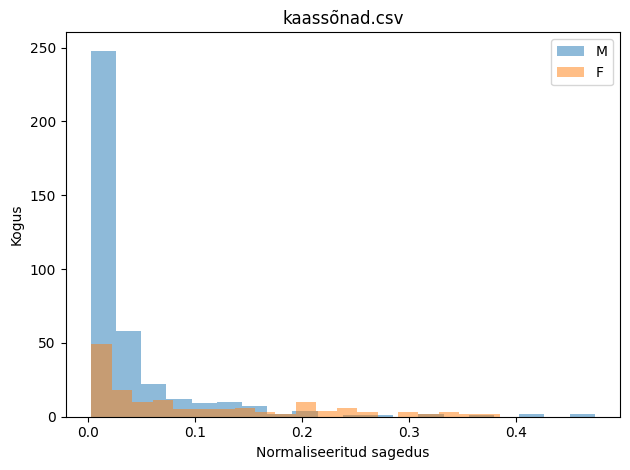

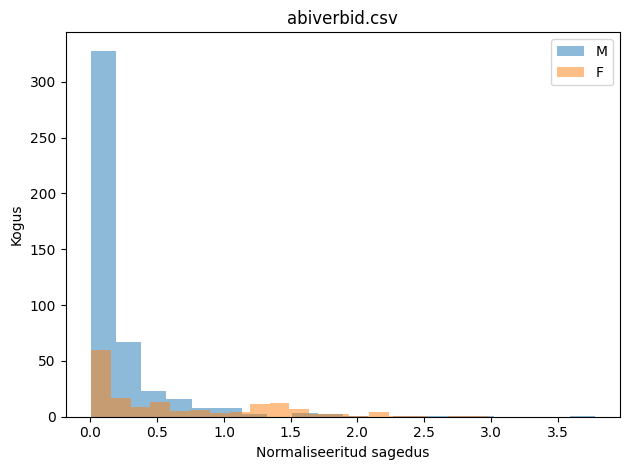

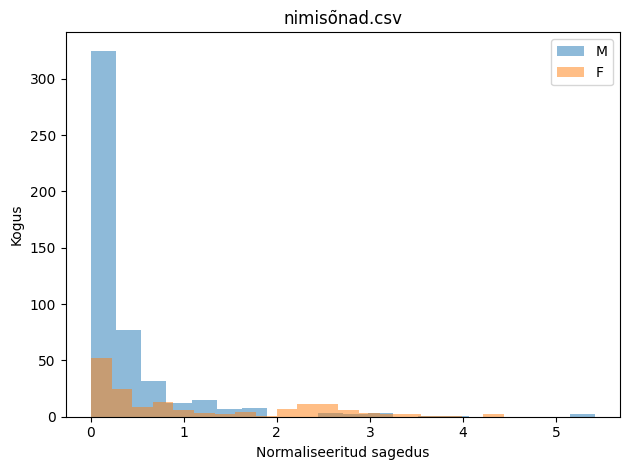

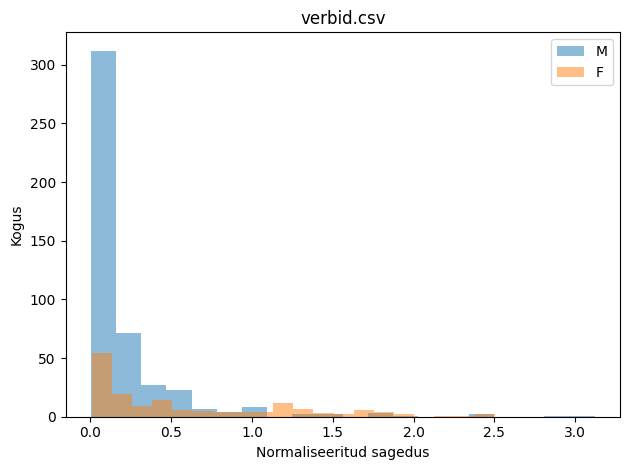

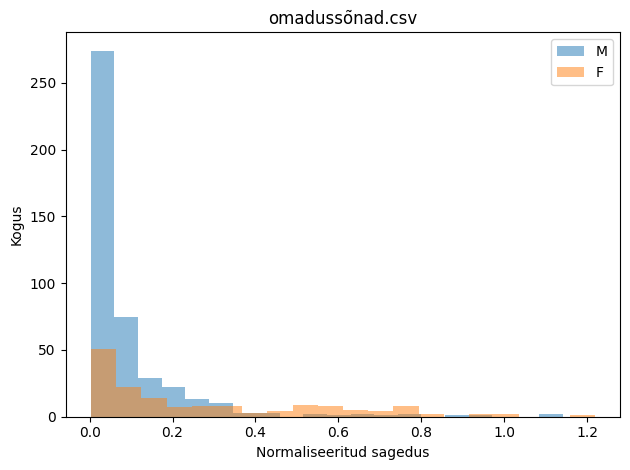

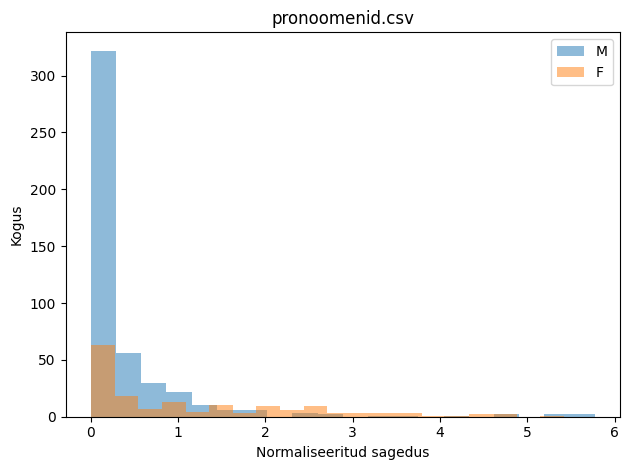

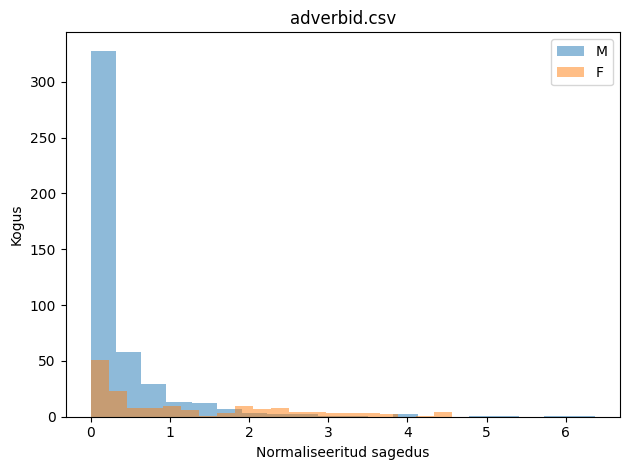

In [5]:
process_all_csvs('pos_sections_csv/pos_sections_counter')

In [6]:
def analüüsi_fail(failitee, raw, norm):
    df = loe_csv_automaatselt(failitee)

    # Valimid normaliseeritud andmetest
    mehed_norm = df[df["gender"] == "M"].iloc[:, norm].dropna()
    naised_norm = df[df["gender"] == "F"].iloc[:, norm].dropna()

    # Mann–Whitney U-test
    U, p_norm = mannwhitneyu(mehed_norm, naised_norm, alternative='two-sided')
    test_norm = "Mann–Whitney U"

    # Rank-biserial effect size (CLES-based)
    cles = pg.compute_effsize(mehed_norm, naised_norm, eftype='CLES')
    r_rb = 2 * cles - 1

    # Absoluutsagedused χ²-testi jaoks (vajaduse korral)
    mehed_raw = df[df["gender"] == "M"].iloc[:, raw].dropna()
    naised_raw = df[df["gender"] == "F"].iloc[:, raw].dropna()
    sum_m, sum_n = mehed_raw.sum(), naised_raw.sum()

    return {
        "failinimi": os.path.basename(failitee),
        "test_norm": test_norm,
        "p_norm": p_norm,
        "sum_m": sum_m,
        "sum_n": sum_n,
        "r_rb": r_rb,
    }

Sõnaliigid: 

In [7]:
from scipy.stats import chi2_contingency
# kõik tulemused
csv_failid = glob.glob(os.path.join("pos_sections_csv/pos_sections_counter", "*.csv"))
tulemused = [analüüsi_fail(f, 5, 6) for f in csv_failid]
kokkuvõte_df = pd.DataFrame(tulemused)

# Holm–Bonferroni 
rej, p_holm, _, _ = multipletests(kokkuvõte_df["p_norm"], alpha=0.05, method='holm')
kokkuvõte_df["p_norm_holm"]      = p_holm
kokkuvõte_df["signif_norm_holm"] = rej

# 3) χ² + Cramer’s V kui signif_norm_holm == True
chi2_stat_lst, p_chi2_lst, cramer_v_lst, signif_chi2_lst = [], [], [], []
for _, row in kokkuvõte_df.iterrows():
    if row["signif_norm_holm"]:
        # 2×2 tabel:        POS      not-POS
        contingency = np.array([[row["sum_m"], total_m - row["sum_m"]],
                                [row["sum_n"], total_n - row["sum_n"]]])

        chi2_stat, p_chi2, _, _ = chi2_contingency(contingency,
                                                   correction=False)  

        N = contingency.sum()          # valimi suurus kokku
        cramer_v = math.sqrt(chi2_stat / N)   # 2×2 tabeli puhul k=1
        signif = p_chi2 < 0.05
    else:
        chi2_stat = p_chi2 = cramer_v = None
        signif = False

    chi2_stat_lst.append(chi2_stat)
    p_chi2_lst.append(p_chi2)
    cramer_v_lst.append(cramer_v)
    signif_chi2_lst.append(signif)

# DataFrame'isse
kokkuvõte_df = kokkuvõte_df.assign(
    chi2_stat   = chi2_stat_lst,
    p_chi2      = p_chi2_lst,
    cramer_v    = cramer_v_lst,
    signif_chi2 = signif_chi2_lst,
)

mask = kokkuvõte_df["p_chi2"].notna()
if mask.any():
    rej_chi2, p_chi2_holm, _, _ = multipletests(
        kokkuvõte_df.loc[mask, "p_chi2"],
        alpha=0.05,
        method='holm'
    )

    kokkuvõte_df.loc[mask, "p_chi2_holm"]      = p_chi2_holm
    kokkuvõte_df.loc[mask, "signif_chi2_holm"] = rej_chi2
else:
    kokkuvõte_df["p_chi2_holm"]      = np.nan
    kokkuvõte_df["signif_chi2_holm"] = False
    
# salvestan
kokkuvõte_df.to_csv("tulemused/tulemused_pos.csv", index=False)
print(kokkuvõte_df)

          failinimi       test_norm        p_norm  sum_m  sum_n      r_rb  \
0    kaassõnad.csv  Mann–Whitney U  1.708909e-13   5297   4357 -0.411052   
1     abiverbid.csv  Mann–Whitney U  1.772006e-16  35326  29889 -0.436420   
2    nimisõnad.csv  Mann–Whitney U  5.633755e-17  60809  50031 -0.439670   
3        verbid.csv  Mann–Whitney U  2.219317e-16  33598  28030 -0.435887   
4  omadussõnad.csv  Mann–Whitney U  4.341531e-16  13586  12417 -0.435374   
5   pronoomenid.csv  Mann–Whitney U  3.185327e-16  64345  53710 -0.431344   
6      adverbid.csv  Mann–Whitney U  6.209889e-18  61625  53225 -0.458412   

    p_norm_holm  signif_norm_holm  chi2_stat        p_chi2  cramer_v  \
0  1.708909e-13              True   0.170152  6.799764e-01  0.000515   
1  8.860031e-16              True   7.106618  7.679986e-03  0.003331   
2  3.380253e-16              True   2.183494  1.394974e-01  0.001846   
3  8.877270e-16              True   0.567412  4.512890e-01  0.000941   
4  9.555980e-16        

In [8]:
def _guess_sep(sample: str) -> str:
    """määrata, millega CSV on eraldatud (',' või ';')."""
    try:
        return csv.Sniffer().sniff(sample, delimiters=[",", ";"]).delimiter
    except csv.Error:
        return ","

In [9]:
def plot_gender_boxplots_separately(
    directory: str,
    norm_col: str = "freq_per_1000_lemmas",
    pattern: str = "*.csv",
    *,
    pad: float = 0.05,                       
    y_label: Optional[str] = None,          
) -> None:
    """
    Koostab iga CSV-faili jaoks eraldi karpdiagrammi (M vs F).
    
    """
    # faili otsing
    csv_files: List[str] = glob.glob(os.path.join(directory, pattern))
    if not csv_files:
        raise FileNotFoundError(
            f"puuduvad mallile vastavad failid «{pattern}» kaustas «{directory}»"
        )

    data: list[tuple[str, pd.Series, pd.Series]] = []

    # andmete lugemine ja filtreerimine
    for fp in csv_files:
        label = os.path.splitext(os.path.basename(fp))[0]          # parameetri nimi

        with open(fp, encoding="utf-8") as f:
            sep = _guess_sep(f.read(2048))

        df = pd.read_csv(fp, sep=sep)
        if {"gender", norm_col}.difference(df.columns):
            # jäta vahele fail, millel ei ole nõutavaid veerge
            continue

        df["gender"] = df["gender"].str.upper().str.strip()
        m = df.loc[df["gender"] == "M", norm_col].dropna()
        f_ = df.loc[df["gender"] == "F", norm_col].dropna()

        if m.empty or f_.empty:
            # jäta vahele, kui ühe soo kohta ei ole andmeid.
            continue

        data.append((label, m, f_))

    if not data:
        raise ValueError("Pärast filtreerimist ei jäänud andmeid analüüsimiseks.")

    # Y-telje koguvahemik
    g_min = min(s.min() for _, m, f_ in data for s in (m, f_))
    g_max = max(s.max() for _, m, f_ in data for s in (m, f_))
    span = g_max - g_min
    vmin, vmax = g_min - span * pad, g_max + span * pad

    # Y-telje pealkiri
    y_axis_label = y_label if y_label else norm_col.replace("_", " ")

    # karpdiagrammid
    for i in range(0, len(data), 2):
        pair = data[i : i + 2]                                   # üks või kaks 
        fig, axes = plt.subplots(1, 2, figsize=(8, 6))

        if not isinstance(axes, (list, np.ndarray)):
            axes = [axes]

        for ax, (label, m, f_) in zip(axes, pair):
            ax.boxplot(
                [m, f_],
                labels=["M", "F"],
                widths=0.6,
                whis=(0, 100),
                showfliers=True,
            )
            ax.set_title(label)
            ax.set_ylabel(y_axis_label)
            ax.set_ylim(vmin, vmax)

            # mediaan
            for pos, series in enumerate([m, f_], start=1):
                med = series.median()
                ax.text(pos, med, f"{med:.2f}", ha="center", va="bottom", fontweight="bold")

        # еkui parameetrite arv on paaritu - teine diagramm on tühi.
        if len(pair) == 1:
            axes[1].axis("off")

        plt.tight_layout()
        plt.show()

/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(
/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


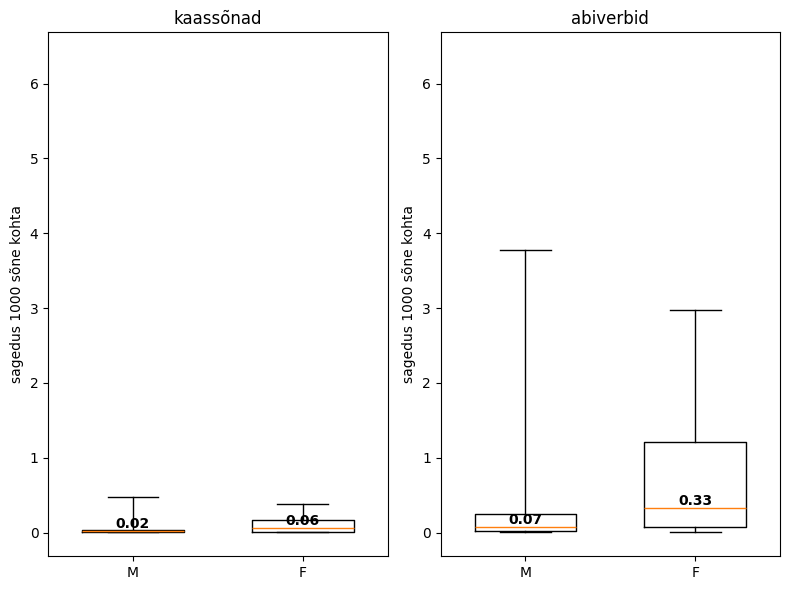

/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(
/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


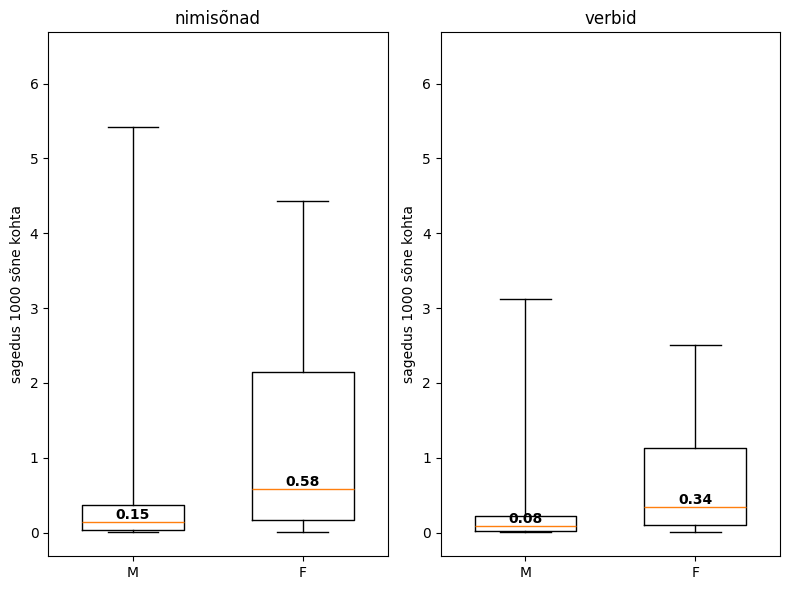

/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(
/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


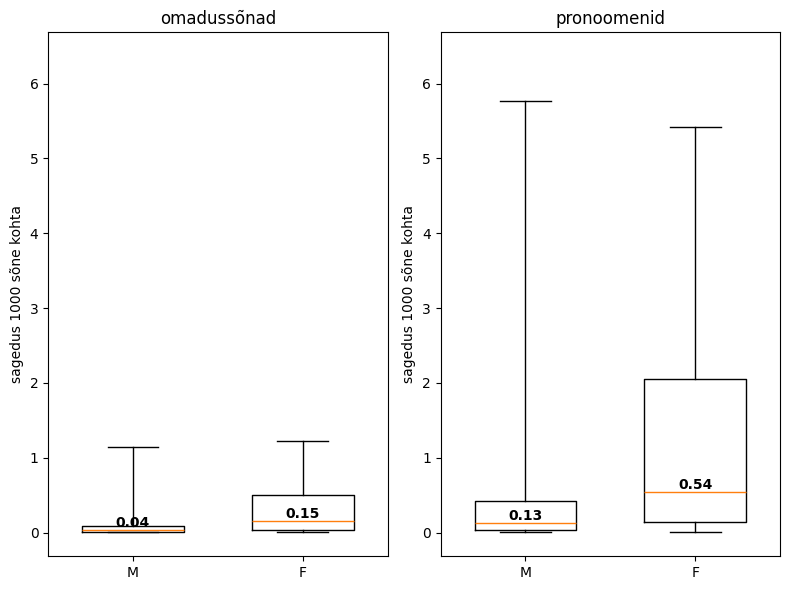

/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


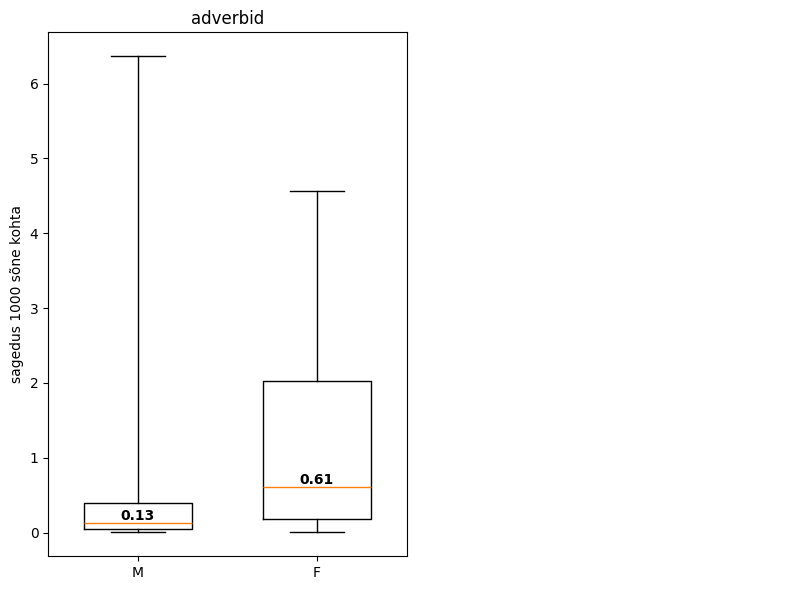

In [10]:
plot_gender_boxplots_separately(
    directory="pos_sections_csv/pos_sections_counter",
    y_label="sagedus 1000 sõne kohta" 
)

Muud tunnused:

In [11]:
# kõik tulemused
csv_failid = glob.glob(os.path.join("tunnused_sections_csv", "*.csv"))
tulemused = [analüüsi_fail(f, 4, 5) for f in csv_failid]
kokkuvõte_df = pd.DataFrame(tulemused)

# Holm–Bonferroni 
rej, p_holm, _, _ = multipletests(kokkuvõte_df["p_norm"], alpha=0.05, method='holm')
kokkuvõte_df["p_norm_holm"]      = p_holm
kokkuvõte_df["signif_norm_holm"] = rej

# 3) χ² + Cramer’s V kui signif_norm_holm == True
chi2_stat_lst, p_chi2_lst, cramer_v_lst, signif_chi2_lst = [], [], [], []
for _, row in kokkuvõte_df.iterrows():
    if row["signif_norm_holm"]:
        # 2×2 tabel:        POS      not-POS
        contingency = np.array([[row["sum_m"], total_m - row["sum_m"]],
                                [row["sum_n"], total_n - row["sum_n"]]])

        chi2_stat, p_chi2, _, _ = chi2_contingency(contingency,
                                                   correction=False)  

        N = contingency.sum()          # valimi suurus kokku
        cramer_v = math.sqrt(chi2_stat / N)   # 2×2 tabeli jaoks k=1
        signif = p_chi2 < 0.05
    else:
        chi2_stat = p_chi2 = cramer_v = None
        signif = False

    chi2_stat_lst.append(chi2_stat)
    p_chi2_lst.append(p_chi2)
    cramer_v_lst.append(cramer_v)
    signif_chi2_lst.append(signif)

# DataFrame'isse
kokkuvõte_df = kokkuvõte_df.assign(
    chi2_stat   = chi2_stat_lst,
    p_chi2      = p_chi2_lst,
    cramer_v    = cramer_v_lst,
    signif_chi2 = signif_chi2_lst,
)
mask = kokkuvõte_df["p_chi2"].notna()
if mask.any():
    rej_chi2, p_chi2_holm, _, _ = multipletests(
        kokkuvõte_df.loc[mask, "p_chi2"],
        alpha=0.05,
        method='holm'
    )

    kokkuvõte_df.loc[mask, "p_chi2_holm"]      = p_chi2_holm
    kokkuvõte_df.loc[mask, "signif_chi2_holm"] = rej_chi2
else:
    kokkuvõte_df["p_chi2_holm"]      = np.nan
    kokkuvõte_df["signif_chi2_holm"] = False
    
#salvestan
kokkuvõte_df.to_csv("tulemused/tulemused_tunnused.csv", index=False)
print(kokkuvõte_df)


                                 failinimi       test_norm        p_norm  \
0                                eitus.csv  Mann–Whitney U  8.366448e-13   
1                     tingiv_kõneviis.csv  Mann–Whitney U  1.581218e-15   
2        intensiivistajad_omadussõnad.csv  Mann–Whitney U  2.275682e-16   
3              intensiivistajad_verbid.csv  Mann–Whitney U  1.617264e-16   
4   esimese_ja_teise_isiku_pronoomenid.csv  Mann–Whitney U  8.888198e-14   
5                     kaskiv_kõneviis.csv  Mann–Whitney U  3.440953e-09   
6                          kp_markerid.csv  Mann–Whitney U  5.152959e-10   
7                           deminutiiv.csv  Mann–Whitney U  6.722850e-12   
8           partiklid_vaata_oota_kuule.csv  Mann–Whitney U  4.296752e-03   
9            intensiivistajad_adverbid.csv  Mann–Whitney U  1.164858e-16   
10               umbisikuline_tegumood.csv  Mann–Whitney U  6.388105e-14   
11                      muud_partiklid.csv  Mann–Whitney U  3.314692e-06   

    sum_m  

/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(
/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


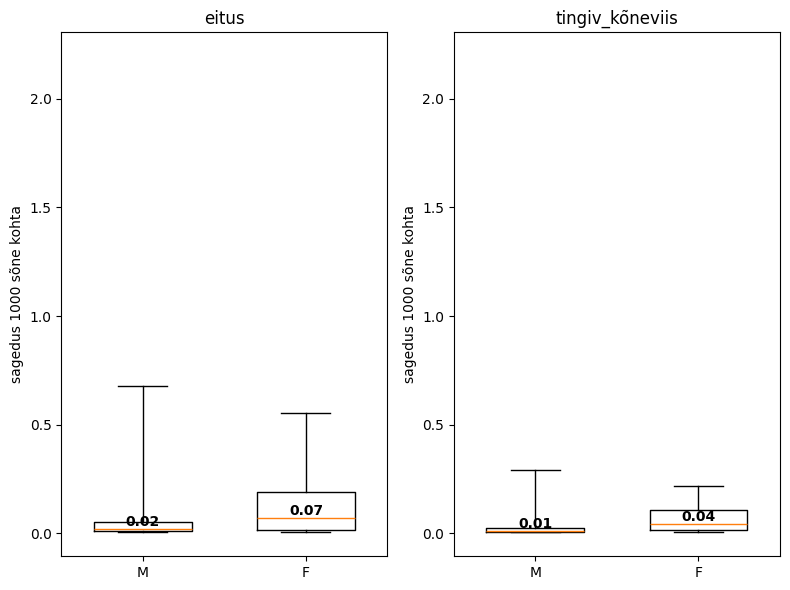

/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(
/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


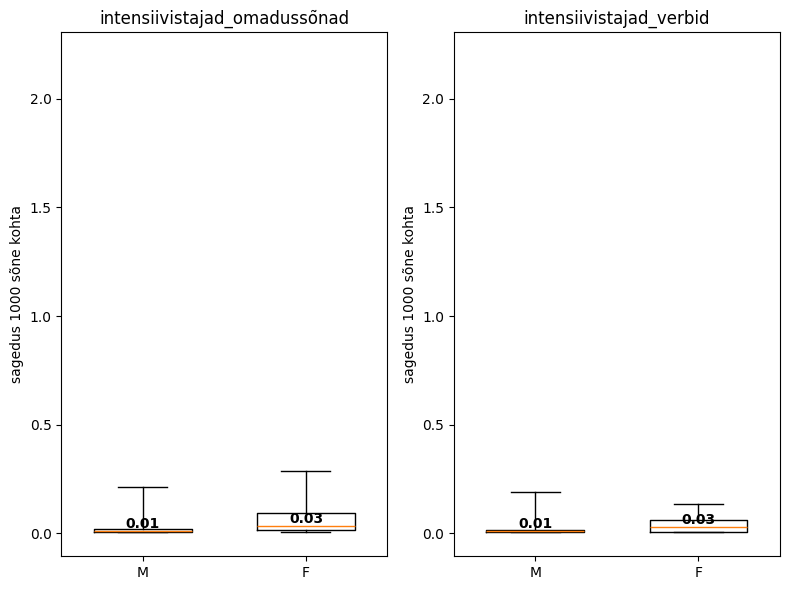

/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(
/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


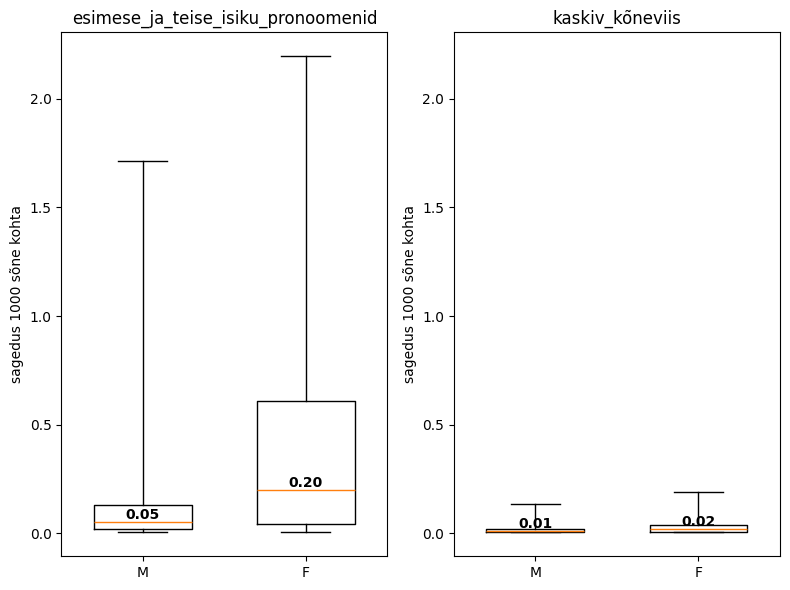

/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(
/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


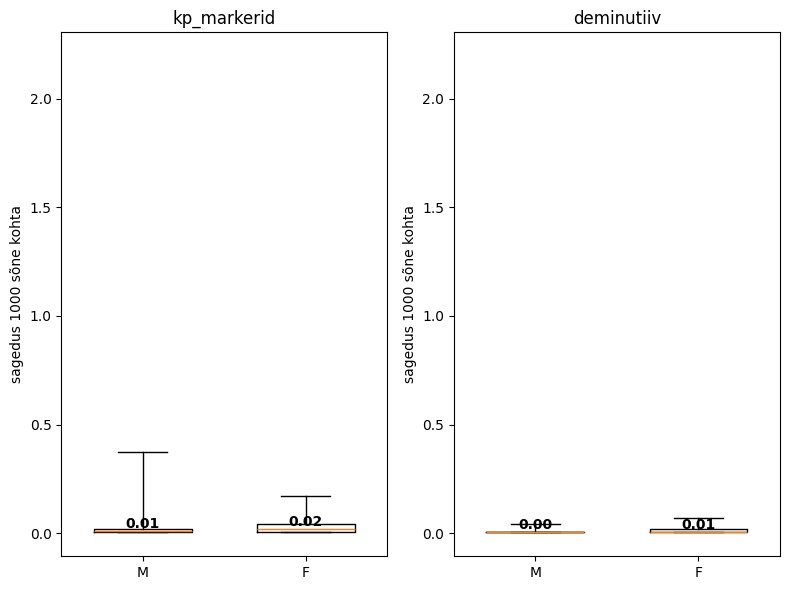

/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(
/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


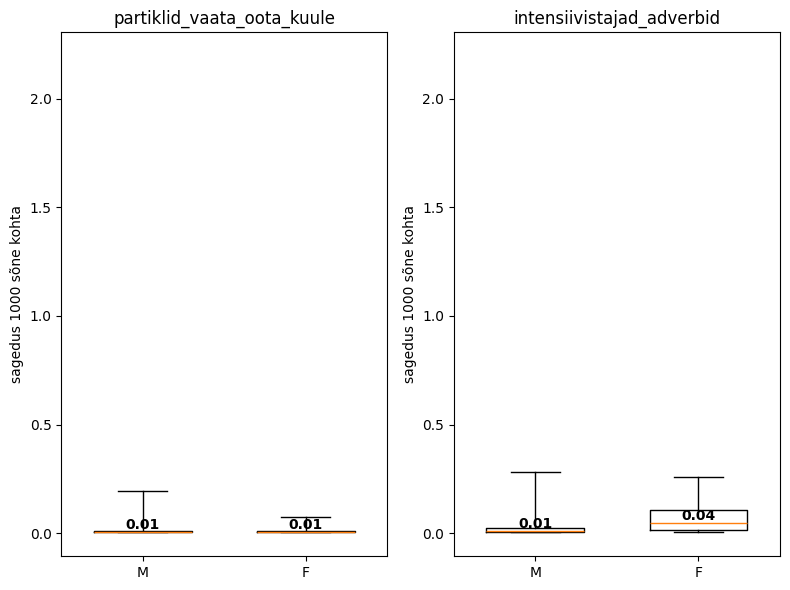

/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(
/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


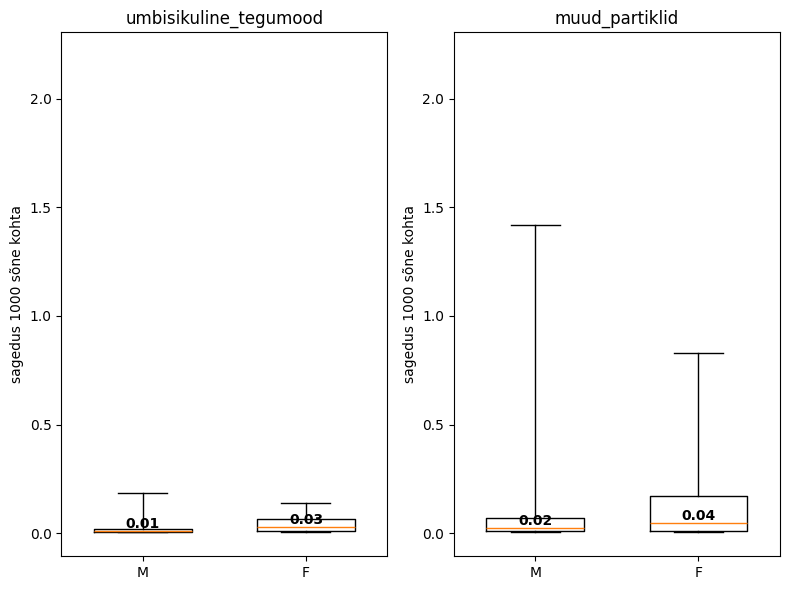

In [12]:
plot_gender_boxplots_separately(directory="tunnused_sections_csv", y_label="sagedus 1000 sõne kohta")

Partiklid:

In [13]:
# kõik tulemused
csv_failid = glob.glob(os.path.join("particles_per_value/sections_particles_per_value", "*.csv"))
tulemused = [analüüsi_fail(f, 4, 5) for f in csv_failid]
kokkuvõte_df = pd.DataFrame(tulemused)

# Holm–Bonferroni 
rej, p_holm, _, _ = multipletests(kokkuvõte_df["p_norm"], alpha=0.05, method='holm')
kokkuvõte_df["p_norm_holm"]      = p_holm
kokkuvõte_df["signif_norm_holm"] = rej

# 3) χ² + Cramer’s V kui signif_norm_holm == True
chi2_stat_lst, p_chi2_lst, cramer_v_lst, signif_chi2_lst = [], [], [], []
for _, row in kokkuvõte_df.iterrows():
    if row["signif_norm_holm"]:
        # 2×2 tabel:        POS      not-POS
        contingency = np.array([[row["sum_m"], total_m - row["sum_m"]],
                                [row["sum_n"], total_n - row["sum_n"]]])

        chi2_stat, p_chi2, _, _ = chi2_contingency(contingency,
                                                   correction=False)

        N = contingency.sum()          # valimi suurus kokku
        cramer_v = math.sqrt(chi2_stat / N)   # 2×2 tabeli jaoks k=1
        signif = p_chi2 < 0.05
    else:
        chi2_stat = p_chi2 = cramer_v = None
        signif = False

    chi2_stat_lst.append(chi2_stat)
    p_chi2_lst.append(p_chi2)
    cramer_v_lst.append(cramer_v)
    signif_chi2_lst.append(signif)

# DataFrame'isse
kokkuvõte_df = kokkuvõte_df.assign(
    chi2_stat   = chi2_stat_lst,
    p_chi2      = p_chi2_lst,
    cramer_v    = cramer_v_lst,
    signif_chi2 = signif_chi2_lst,
)
mask = kokkuvõte_df["p_chi2"].notna()
if mask.any():
    rej_chi2, p_chi2_holm, _, _ = multipletests(
        kokkuvõte_df.loc[mask, "p_chi2"],
        alpha=0.05,
        method='holm'
    )

    kokkuvõte_df.loc[mask, "p_chi2_holm"]      = p_chi2_holm
    kokkuvõte_df.loc[mask, "signif_chi2_holm"] = rej_chi2
else:
    kokkuvõte_df["p_chi2_holm"]      = np.nan
    kokkuvõte_df["signif_chi2_holm"] = False
    
#salvestan
kokkuvõte_df.to_csv("tulemused/tulemused_partiklid.csv", index=False)
print(kokkuvõte_df)


     failinimi       test_norm        p_norm  sum_m  sum_n      r_rb  \
0      jah.csv  Mann–Whitney U  1.251070e-05     67     44 -0.535802   
1    jumal.csv  Mann–Whitney U  1.230664e-06     90     37 -0.601737   
2     okei.csv  Mann–Whitney U  6.804291e-05    225    124 -0.404635   
3     nagu.csv  Mann–Whitney U  3.559777e-04   7225   3732 -0.207371   
4      vot.csv  Mann–Whitney U  2.598828e-04     74     59 -0.495895   
5      noh.csv  Mann–Whitney U  2.505540e-07    345    230 -0.445445   
6  eks_ole.csv  Mann–Whitney U  1.207269e-04    209    293 -0.405238   
7       oh.csv  Mann–Whitney U  3.711261e-05     39     19 -0.727047   
8       no.csv  Mann–Whitney U  2.149289e-03    474    195 -0.260274   

   p_norm_holm  signif_norm_holm   chi2_stat         p_chi2  cramer_v  \
0     0.000088              True    1.455111   2.277096e-01  0.001507   
1     0.000010              True   13.459977   2.437067e-04  0.004584   
2     0.000340              True   13.556627   2.314727e-04 

/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(
/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


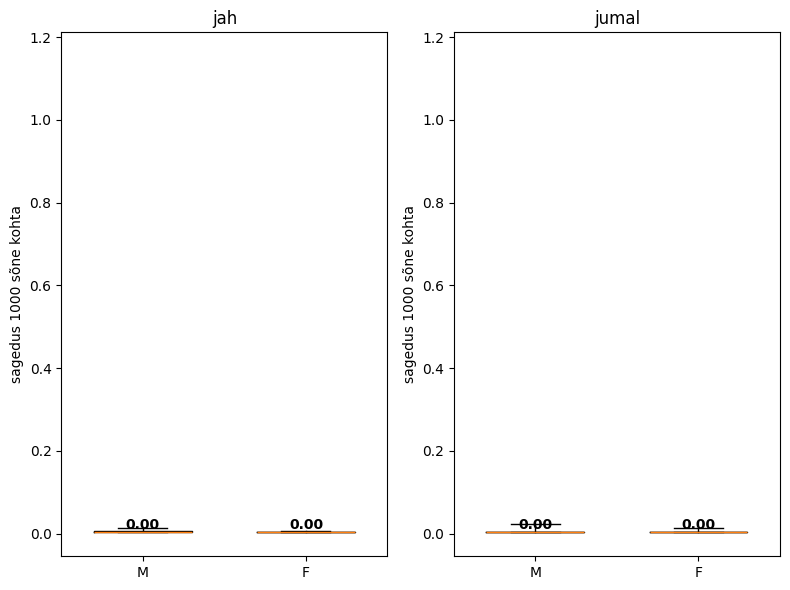

/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(
/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


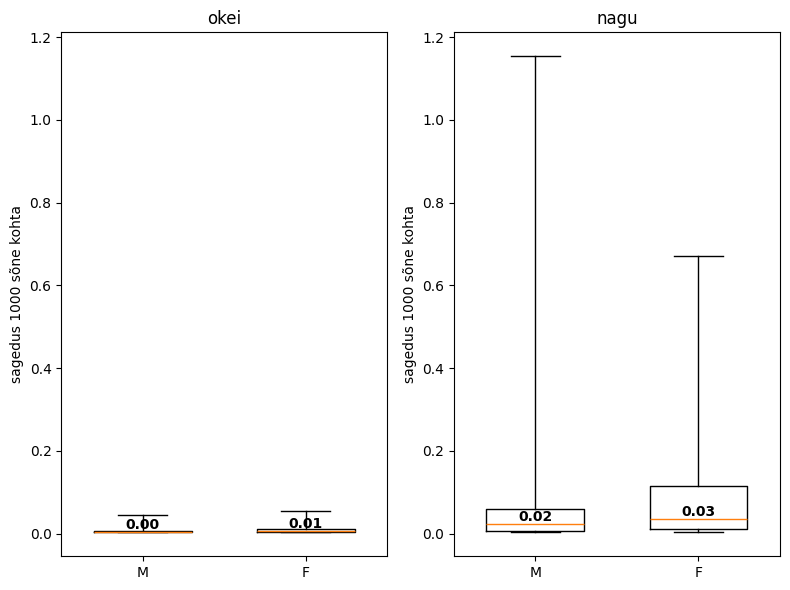

/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(
/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


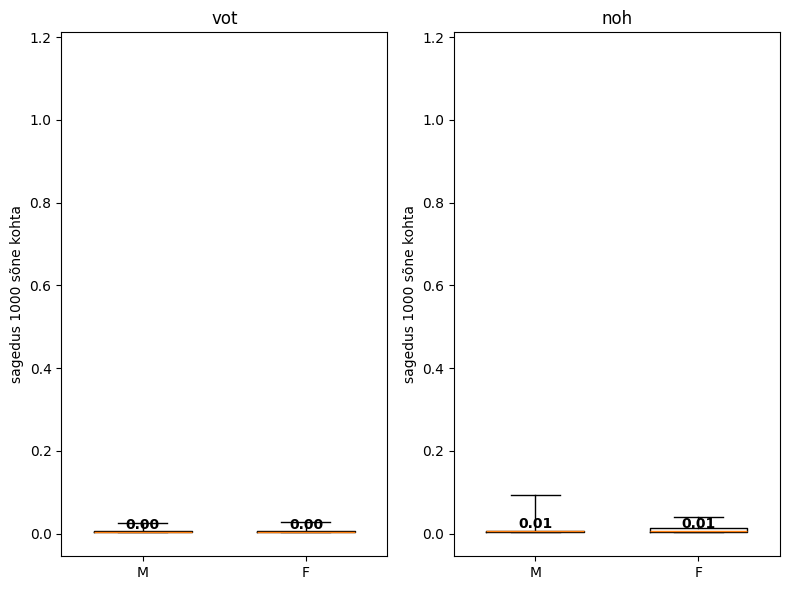

/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(
/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


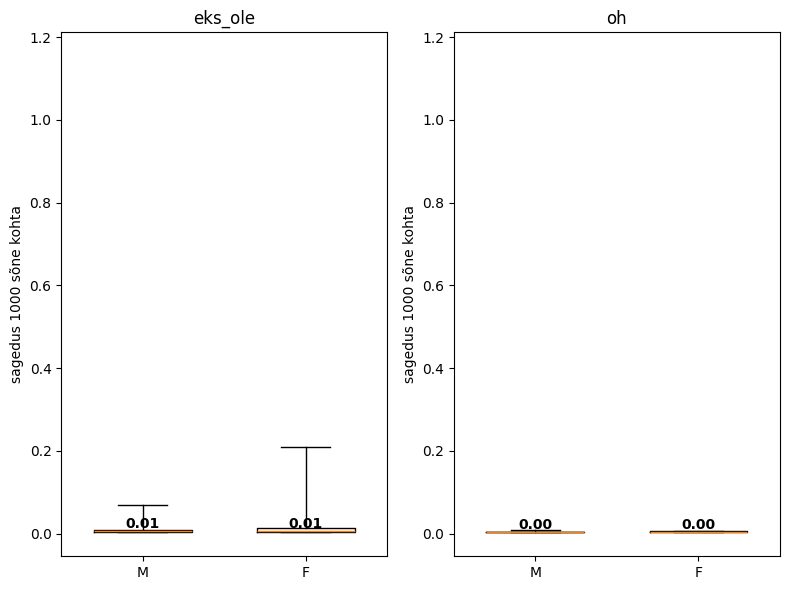

/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


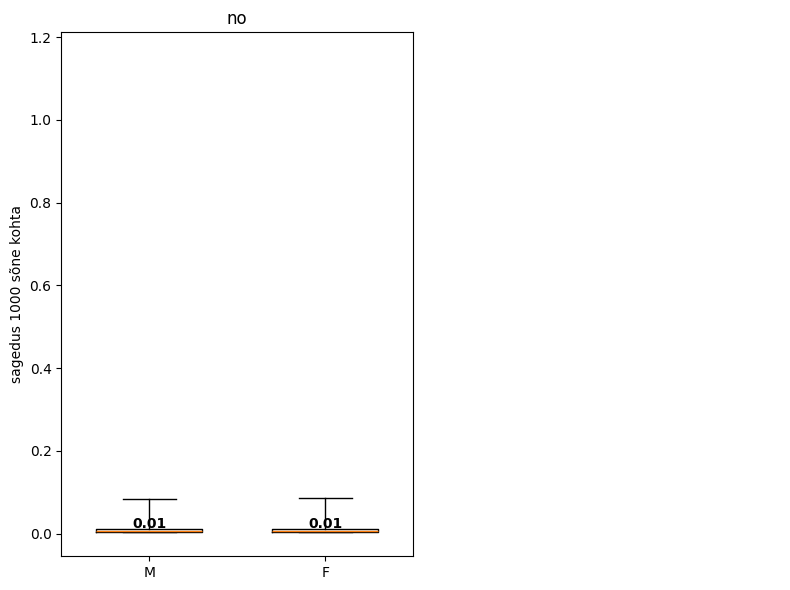

In [14]:
plot_gender_boxplots_separately(directory="particles_per_value/sections_particles_per_value", y_label= 'sagedus 1000 sõne kohta')

KP-markerid:

In [15]:
# kõik tulemused
csv_failid = glob.glob(os.path.join("kp_markerid_per_value/sections_kp_markerid_per_value", "*.csv"))
tulemused = [analüüsi_fail(f, 4, 5) for f in csv_failid]
kokkuvõte_df = pd.DataFrame(tulemused)

# Holm–Bonferroni 
rej, p_holm, _, _ = multipletests(kokkuvõte_df["p_norm"], alpha=0.05, method='holm')
kokkuvõte_df["p_norm_holm"]      = p_holm
kokkuvõte_df["signif_norm_holm"] = rej

# 3) χ² + Cramer’s V kui signif_norm_holm == True
chi2_stat_lst, p_chi2_lst, cramer_v_lst, signif_chi2_lst = [], [], [], []
for _, row in kokkuvõte_df.iterrows():
    if row["signif_norm_holm"]:
        # 2×2 tabel:        POS      not-POS
        contingency = np.array([[row["sum_m"], total_m - row["sum_m"]],
                                [row["sum_n"], total_n - row["sum_n"]]])

        chi2_stat, p_chi2, _, _ = chi2_contingency(contingency,
                                                   correction=False)  

        N = contingency.sum()          # valimi suurus kokku
        cramer_v = math.sqrt(chi2_stat / N)   # 2×2 tabeli jaoks k=1
        signif = p_chi2 < 0.05
    else:
        chi2_stat = p_chi2 = cramer_v = None
        signif = False

    chi2_stat_lst.append(chi2_stat)
    p_chi2_lst.append(p_chi2)
    cramer_v_lst.append(cramer_v)
    signif_chi2_lst.append(signif)

# DataFrame'isse
kokkuvõte_df = kokkuvõte_df.assign(
    chi2_stat   = chi2_stat_lst,
    p_chi2      = p_chi2_lst,
    cramer_v    = cramer_v_lst,
    signif_chi2 = signif_chi2_lst,
)
mask = kokkuvõte_df["p_chi2"].notna()
if mask.any():
    rej_chi2, p_chi2_holm, _, _ = multipletests(
        kokkuvõte_df.loc[mask, "p_chi2"],
        alpha=0.05,
        method='holm'
    )

    kokkuvõte_df.loc[mask, "p_chi2_holm"]      = p_chi2_holm
    kokkuvõte_df.loc[mask, "signif_chi2_holm"] = rej_chi2
else:
    kokkuvõte_df["p_chi2_holm"]      = np.nan
    kokkuvõte_df["signif_chi2_holm"] = False

#salvestan
kokkuvõte_df.to_csv("tulemused/tulemused_kp.csv", index=False)
print(kokkuvõte_df)


    failinimi       test_norm        p_norm  sum_m  sum_n      r_rb  \
0  tundub.csv  Mann–Whitney U  7.603629e-07    166    125 -0.462736   
1  loodan.csv  Mann–Whitney U  1.262790e-05     56     41 -0.582843   
2  ütlen.csv  Mann–Whitney U  2.663921e-06    570    360 -0.363119   
3   arvan.csv  Mann–Whitney U  3.008416e-04    642    362 -0.271650   
4    usun.csv  Mann–Whitney U  2.571712e-09     71     71 -0.694340   

    p_norm_holm  signif_norm_holm  chi2_stat        p_chi2  cramer_v  \
0  3.041452e-06              True   0.667456  4.139399e-01  0.001021   
1  2.525579e-05              True   0.369170  5.434568e-01  0.000759   
2  7.991764e-06              True  16.515760  4.824738e-05  0.005078   
3  3.008416e-04              True  34.967134  3.353176e-09  0.007388   
4  1.285856e-08              True   1.245086  2.644931e-01  0.001394   

   signif_chi2   p_chi2_holm signif_chi2_holm  
0        False  8.278799e-01            False  
1        False  8.278799e-01            Fals

/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(
/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


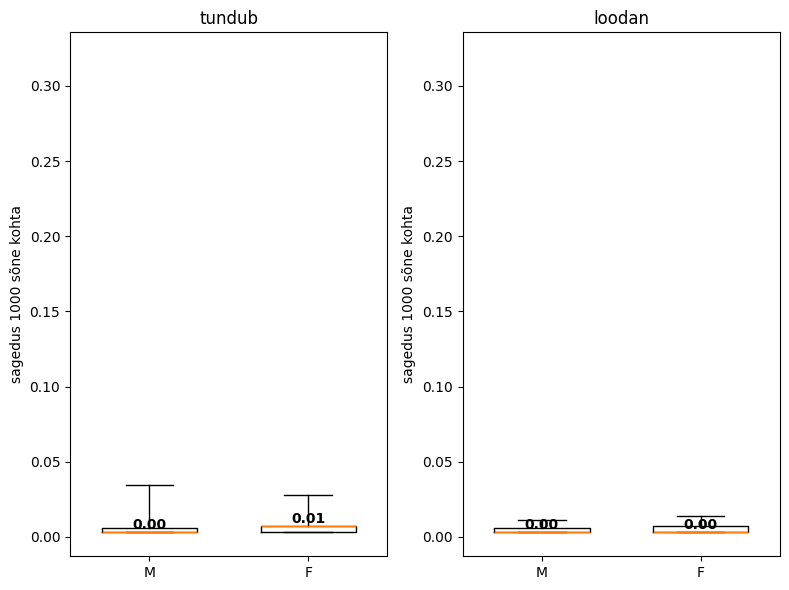

/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(
/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


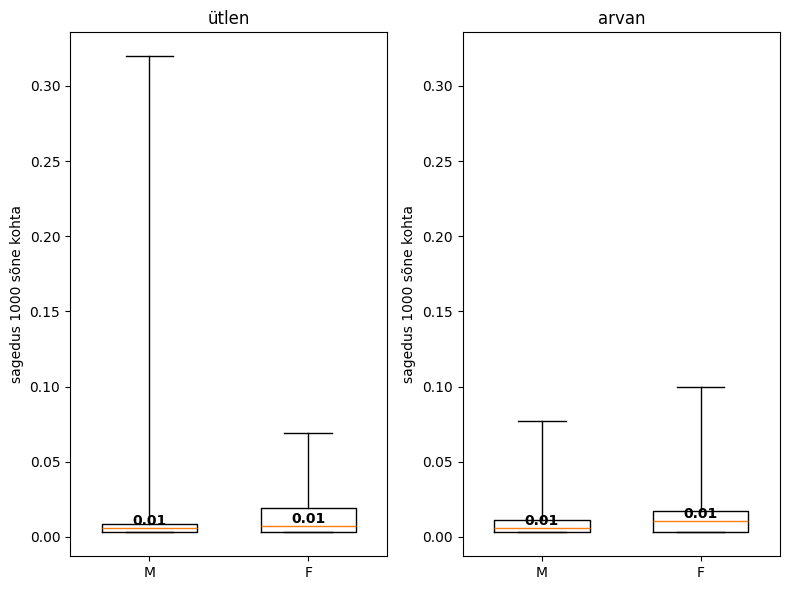

/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


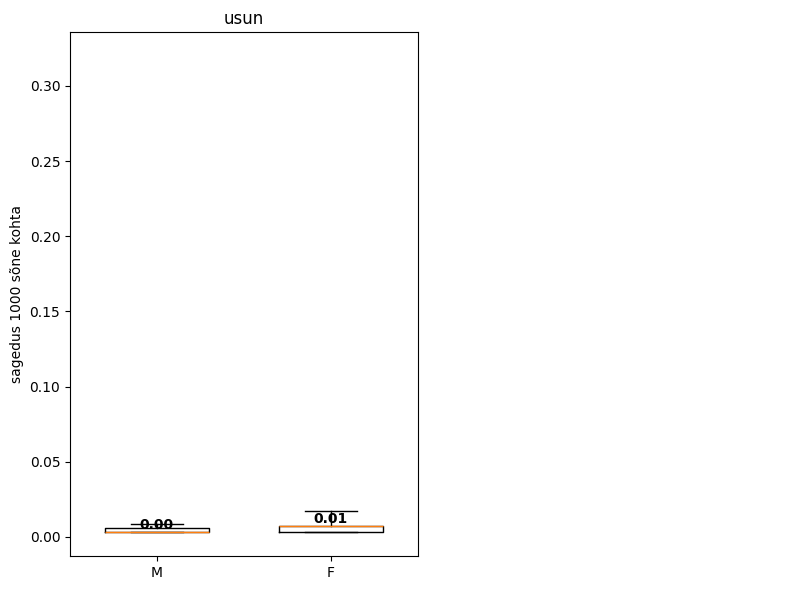

In [16]:
plot_gender_boxplots_separately(directory="kp_markerid_per_value/sections_kp_markerid_per_value",  y_label= 'sagedus 1000 sõne kohta')

Intensiivistajad:

In [17]:
# kõik tulemused
csv_failid = glob.glob(os.path.join("intensiivistajad_per_value/sections_intensiivistajad_per_value", "*.csv"))
tulemused = [analüüsi_fail(f, 4, 5) for f in csv_failid]
kokkuvõte_df = pd.DataFrame(tulemused)

# Holm–Bonferroni 
rej, p_holm, _, _ = multipletests(kokkuvõte_df["p_norm"], alpha=0.05, method='holm')
kokkuvõte_df["p_norm_holm"]      = p_holm
kokkuvõte_df["signif_norm_holm"] = rej

# 3) χ² + Cramer’s V kui signif_norm_holm == True
chi2_stat_lst, p_chi2_lst, cramer_v_lst, signif_chi2_lst = [], [], [], []
for _, row in kokkuvõte_df.iterrows():
    if row["signif_norm_holm"]:
        # 2×2 tabel:        POS      not-POS
        contingency = np.array([[row["sum_m"], total_m - row["sum_m"]],
                                [row["sum_n"], total_n - row["sum_n"]]])

        chi2_stat, p_chi2, _, _ = chi2_contingency(contingency,
                                                   correction=False) 

        N = contingency.sum()          # valimi suurus kokku
        cramer_v = math.sqrt(chi2_stat / N)   # 2×2 tabeli jaoks k=1
        signif = p_chi2 < 0.05
    else:
        chi2_stat = p_chi2 = cramer_v = None
        signif = False

    chi2_stat_lst.append(chi2_stat)
    p_chi2_lst.append(p_chi2)
    cramer_v_lst.append(cramer_v)
    signif_chi2_lst.append(signif)

# DataFrame'isse
kokkuvõte_df = kokkuvõte_df.assign(
    chi2_stat   = chi2_stat_lst,
    p_chi2      = p_chi2_lst,
    cramer_v    = cramer_v_lst,
    signif_chi2 = signif_chi2_lst,
)
mask = kokkuvõte_df["p_chi2"].notna()
if mask.any():
    rej_chi2, p_chi2_holm, _, _ = multipletests(
        kokkuvõte_df.loc[mask, "p_chi2"],
        alpha=0.05,
        method='holm'
    )

    kokkuvõte_df.loc[mask, "p_chi2_holm"]      = p_chi2_holm
    kokkuvõte_df.loc[mask, "signif_chi2_holm"] = rej_chi2
else:
    kokkuvõte_df["p_chi2_holm"]      = np.nan
    kokkuvõte_df["signif_chi2_holm"] = False

#salvestan
kokkuvõte_df.to_csv("tulemused/tulemused_intensiivistajad.csv", index=False)
print(kokkuvõte_df)

           failinimi       test_norm        p_norm  sum_m  sum_n      r_rb  \
0         päris.csv  Mann–Whitney U  2.187499e-08    312    248 -0.447731   
1          liiga.csv  Mann–Whitney U  3.105904e-06    123     79 -0.521127   
2          üsna.csv  Mann–Whitney U  4.309849e-03     86     55 -0.387147   
3   absoluutselt.csv  Mann–Whitney U  1.317769e-03     56     30 -0.502857   
4         üldse.csv  Mann–Whitney U  1.246169e-11    227    269 -0.541340   
5          eriti.csv  Mann–Whitney U  1.524186e-08     81     43 -0.674082   
6       täiesti.csv  Mann–Whitney U  7.004241e-08    149    171 -0.506494   
7          palju.csv  Mann–Whitney U  3.043449e-10    318    424 -0.479119   
8            kui.csv  Mann–Whitney U  3.670859e-17   1043    981 -0.535739   
9         natuke.csv  Mann–Whitney U  1.202041e-06    174    130 -0.461569   
10        hästi.csv  Mann–Whitney U  5.567700e-13    395    567 -0.557477   
11      natukene.csv  Mann–Whitney U  3.223973e-08     90    125

/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(
/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


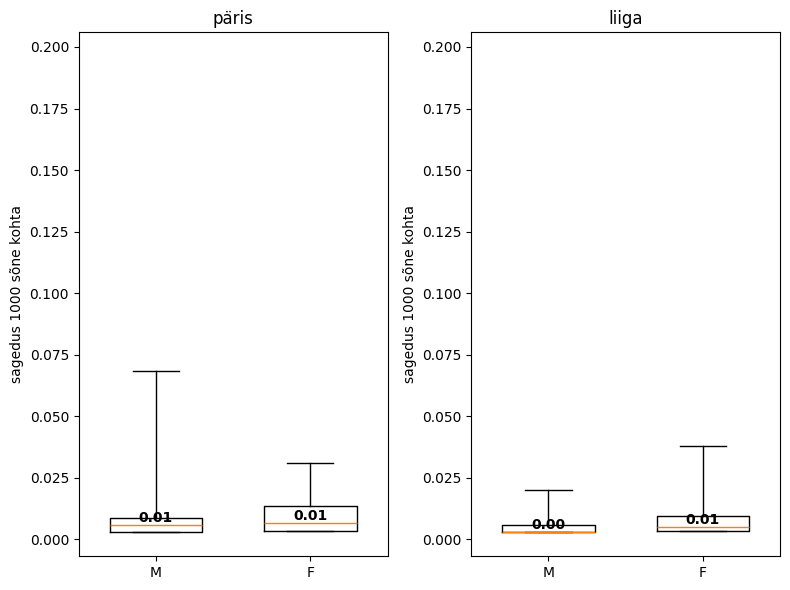

/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(
/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


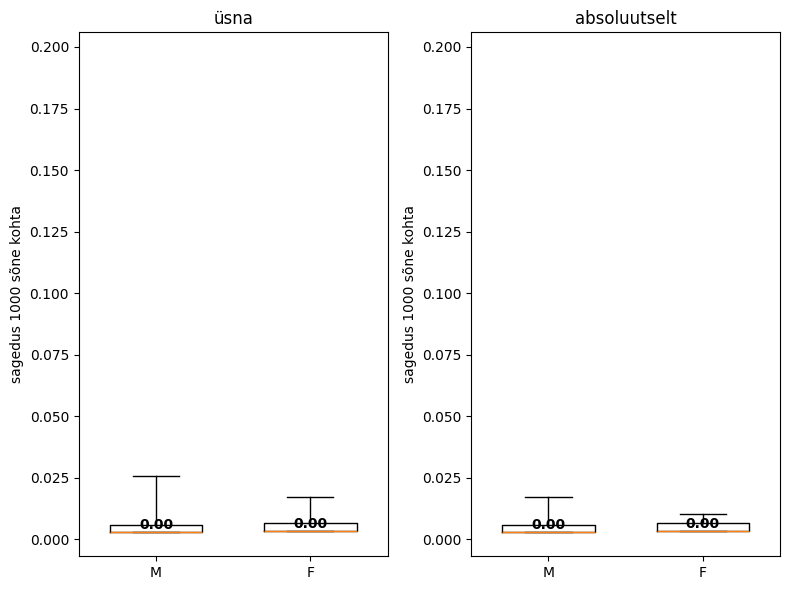

/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(
/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


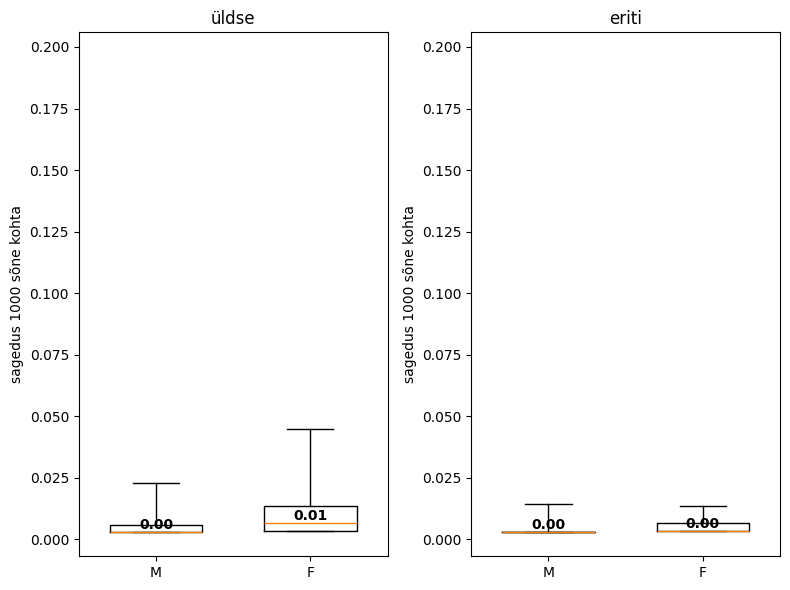

/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(
/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


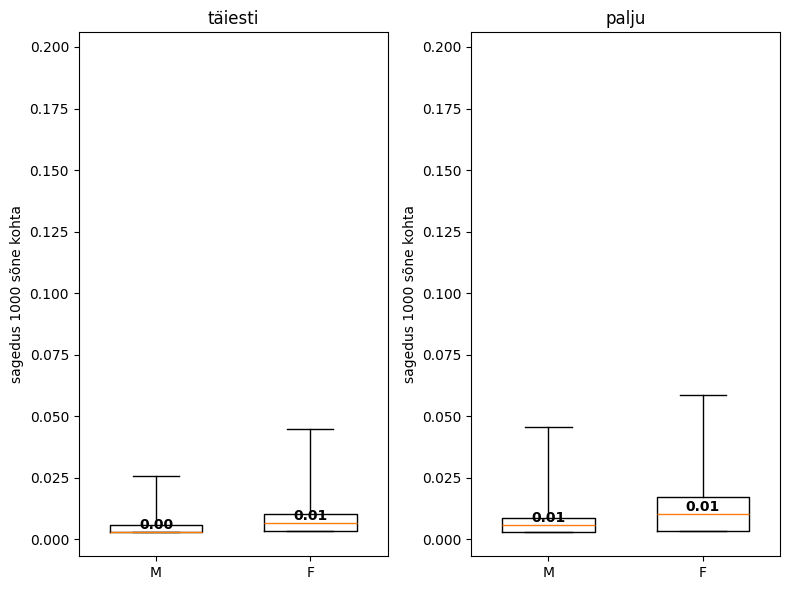

/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(
/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


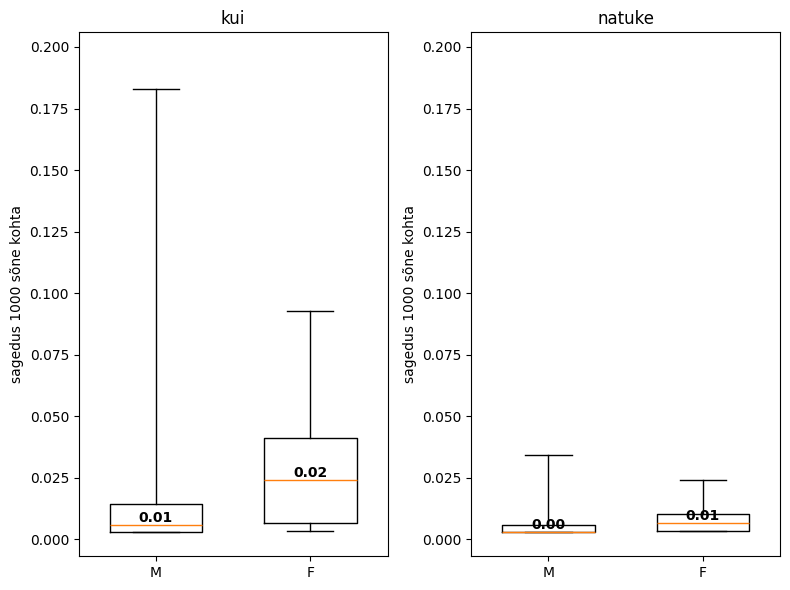

/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(
/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


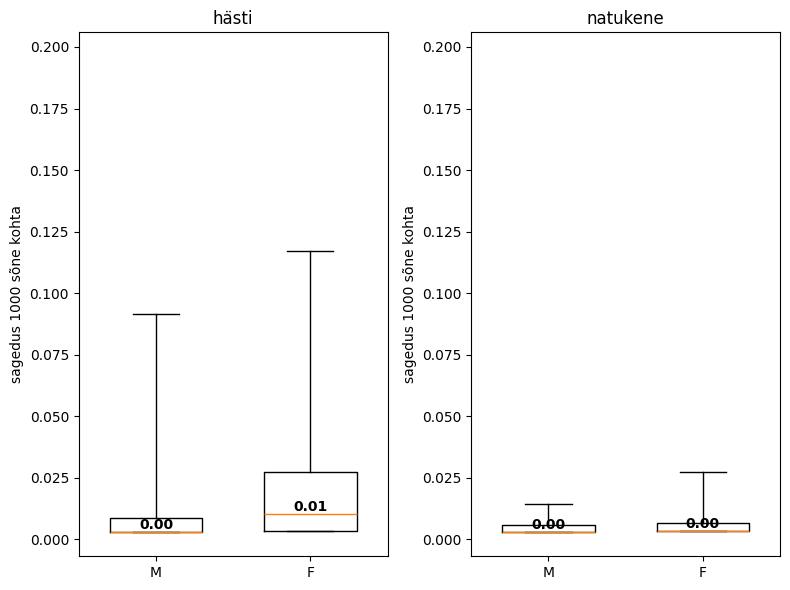

/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(
/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


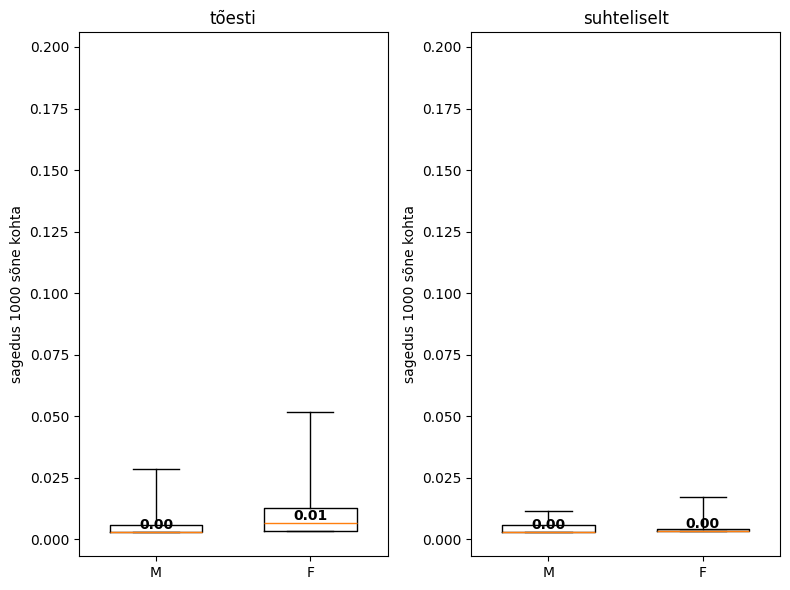

/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(
/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


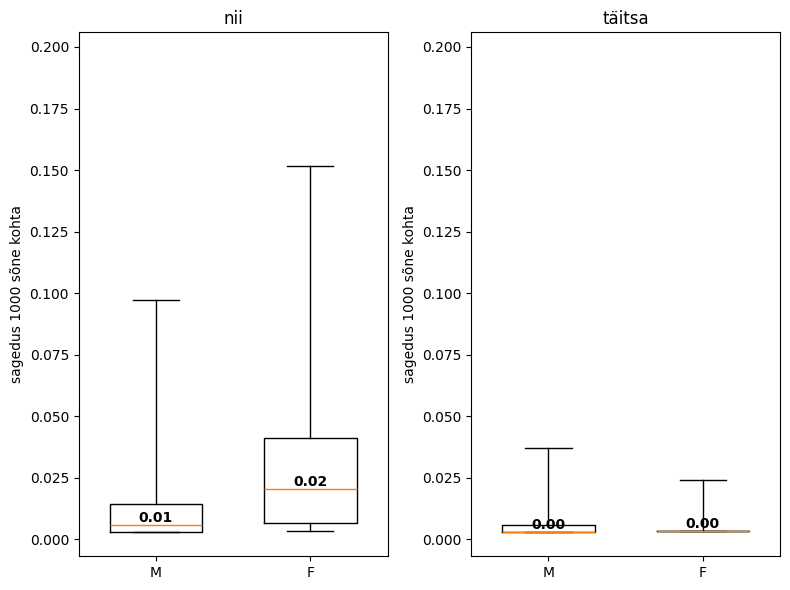

/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(
/var/folders/6g/70z4bwk11l771tqx2cthhf6h0000gn/T/ipykernel_90240/3717202847.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


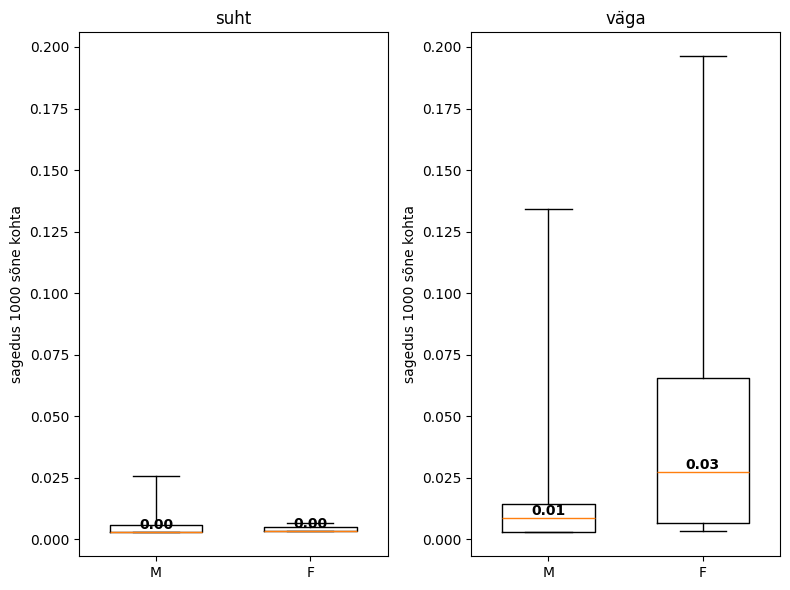

In [18]:
plot_gender_boxplots_separately(directory="intensiivistajad_per_value/sections_intensiivistajad_per_value", y_label= 'sagedus 1000 sõne kohta')